## Loading

In [1]:
%reload_ext autoreload
%autoreload 2

## Python version

In [2]:
# Python versions
import sys, site
print("Python:", sys.executable)
print("User site:", site.getusersitepackages())
print("Site-packages:", site.getsitepackages() if hasattr(site, "getsitepackages") else "n/a")

Python: /home/nicolas/Documents/PhD/Workspace/.venv/bin/python
User site: /home/nicolas/.local/lib/python3.12/site-packages
Site-packages: ['/home/nicolas/Documents/PhD/Workspace/.venv/lib/python3.12/site-packages', '/home/nicolas/Documents/PhD/Workspace/.venv/local/lib/python3.12/dist-packages', '/home/nicolas/Documents/PhD/Workspace/.venv/lib/python3/dist-packages', '/home/nicolas/Documents/PhD/Workspace/.venv/lib/python3.12/dist-packages']


## Librairies

In [3]:
# System and files
import os
import pickle
from tqdm import tqdm
from pathlib import Path
from dataclasses import dataclass

# Files and data
import itertools
import collections
import numpy as np
import polars as pl
import pyarrow.parquet as pq
from dataclasses import fields

# Vizualization
from matplotlib import pyplot as plt
from tqdm import tqdm

# Personal package
import ncl.plots as nclp

## File Reading

In [4]:
def find_parquet_and_load(     
        base_folder = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "2025-01-01_PSMN",
        **params
) -> pl.DataFrame:
    """
    Search for a parquet file in folder subfolders and check the specified values.
    Then load the parquet file as a Polars DataFrame.

    Args:
        root_directory (str): The root directory path to browse.
        **params: Keyword arguments representing the values to check in folder names.

    Returns:
        pl.DataFrame or None: Returns a Polars DataFrame if a matching file is found, otherwise None.
    """

    # List of subfolders in the root folder
    subdirs = [
        os.path.join(base_folder, d)
        for d in os.listdir(base_folder)
        if os.path.isdir(os.path.join(base_folder, d))
    ]

    # Main loop to iterate over subfolders
    for subdir in tqdm(subdirs, desc="Loading subfiles", unit=" subfiles"):
        for dirpath, dirnames, filenames in os.walk(subdir):  # Browse subfolders
            for dirname in dirnames:
                folder_name = dirname

                # Check if all parameters match in the folder name
                if all(f"{key}_{value}__" in folder_name for key, value in params.items()):
                    # Path of the matching subfolder
                    subdir_path = os.path.join(dirpath, folder_name)
                    print(f"Corresponding subfile found: {subdir_path}")

                    # Look for .parquet files with 'data' in their name
                    for filename in os.listdir(subdir_path):
                        if filename.endswith('.parquet') and 'data' in filename:
                            pq_path = os.path.join(subdir_path, filename)
                            try:
                                # Load data using pyarrow and convert to Polars DataFrame
                                data = pq.read_table(pq_path)
                                df_polars = pl.DataFrame(data)
                                pl.Config.set_tbl_cols(len(df_polars.columns))
                                # Prints
                                # print('Values:', df_polars.columns)
                                # print(df_polars.head())
                                # print('Verification of data availability:', df_polars['times'].to_numpy())
                                print('File loaded and data availables')
                                return df_polars
                            except Exception as e:
                                print("Error loading parquet:", e)
                                return None

    # No matching folders found
    print("No sub-folders match the specified criteria.")
    return None


# Parameters
params = {
    "alpha_choice": "periodic",
    "s": 150,
    "l": 10,
    "bpmin": 0,
    
    "mu": 400,
    "theta": 50,
    
    "nt": 10_000,
    
    # "tmax": 100,
    # "dt": 1,
    # "alphao": 0,
    # "alphaf": 1,
    # "beta": 0,
    # "Lmin": 0,
    # "Lmax": 50_000,
    # "origin": 10_000,
    # "bps": 1,
}

# Call
df_polars = find_parquet_and_load(**params)

Loading subfiles:  35%|███▌      | 34/96 [00:00<00:00, 62.65 subfiles/s] 

Corresponding subfile found: /home/nicolas/Documents/PhD/Workspace/nucleo/outputs/2025-01-01_PSMN/data_nucleo_nu_task_12/__alpha_choice_periodic__s_150__l_10__bpmin_0__mu_400__theta_50__nt_10000__tmax_100__dt_1__alphao_0__alphaf_1__beta_0__Lmin_0__Lmax_50000__origin_10000__bps_1__
File loaded and data availables


## Extracting Values

In [5]:
@dataclass(slots=True, kw_only=True, frozen=True)
class SimulationData:
    # Inputs
    alpha_choice: str; s: int; l: int; bpmin: int; 
    mu: float; theta: float
    nt: int; tmax: float; dt: float; times: np.ndarray
    alphao: float; alphaf: float; beta: float; 
    Lmin: int; Lmax: int; origin: int; bps: int

    # Obstacle
    alpha_mean: np.ndarray; obs_points: np.ndarray; obs_distrib: np.ndarray
    link_points: np.ndarray; link_distrib: np.ndarray; link_view: np.ndarray

    # Probabilities
    p: np.ndarray

    # Results
    results: np.ndarray; results_mean: np.ndarray; results_med: np.ndarray
    results_std: np.ndarray; v_mean: float; v_med: float

    # Fitting
    vf: float; vf_std: float; Cf: float; Cf_std: float; wf: float; wf_std: float

    # First pass times
    bin_fpt: int; fpt_distrib_2D: np.ndarray; fpt_number: np.ndarray

    # Time between jumps
    tbj_points: np.ndarray; tbj_distrib: np.ndarray

    # Instantaneous speeds
    dx_points: np.ndarray; dx_distrib: np.ndarray; dx_mean: float
    dx_med: float; dx_mp: float
    dt_points: np.ndarray; dt_distrib: np.ndarray; dt_mean: float
    dt_med: float; dt_mp: float
    vi_points: np.ndarray; vi_distrib: np.ndarray; vi_mean: float
    vi_med: float; vi_mp: float

    # Last parameters
    alpha_0: float

    # Plot tools
    xt_over_t: np.ndarray; G: np.ndarray; bound_low: float; bound_high: float

    @classmethod
    def from_polars(cls, df: pl.DataFrame):
        # Safety: we expect exactly one row
        if df.height == 0:
            raise ValueError("Empty DataFrame")
        if df.height > 1:
            df = df.head(1)

        # Grab the first row ONCE
        row = df.row(0, named=True)  # dict[str, Any]

        # Helper to turn list-like into np.ndarray (no copy if already ndarray)
        def to_np(x):
            return x if isinstance(x, np.ndarray) else np.asarray(x)

        # Columns that should become numpy arrays
        np_keys = {
            "times","alpha_mean","obs_points","obs_distrib",
            "link_points","link_distrib","link_view","p","results",
            "results_mean","results_med","results_std",
            "fpt_distrib_2D","fpt_number","tbj_points","tbj_distrib",
            "dx_points","dx_distrib","dt_points","dt_distrib",
            "vi_points","vi_distrib","xt_over_t","G"
        }

        # Convert only what’s needed
        converted = {k: (to_np(v) if k in np_keys else v) for k, v in row.items()}

        # Build the object (missing args will raise cleanly if schema drifts)
        return cls(**converted)


# Extracting
sim_data = SimulationData.from_polars(df_polars)
print("Values loaded")

Values loaded


## Illustrating

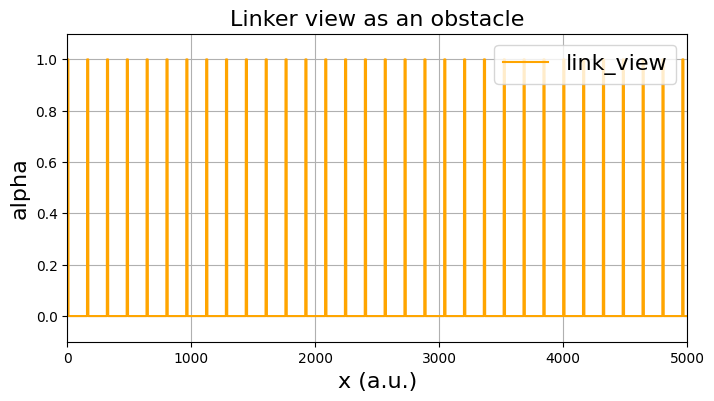

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))
f, args = (nclp.plot_linker_view, (sim_data.link_view,))
f(*args, ax=ax)
plt.show()

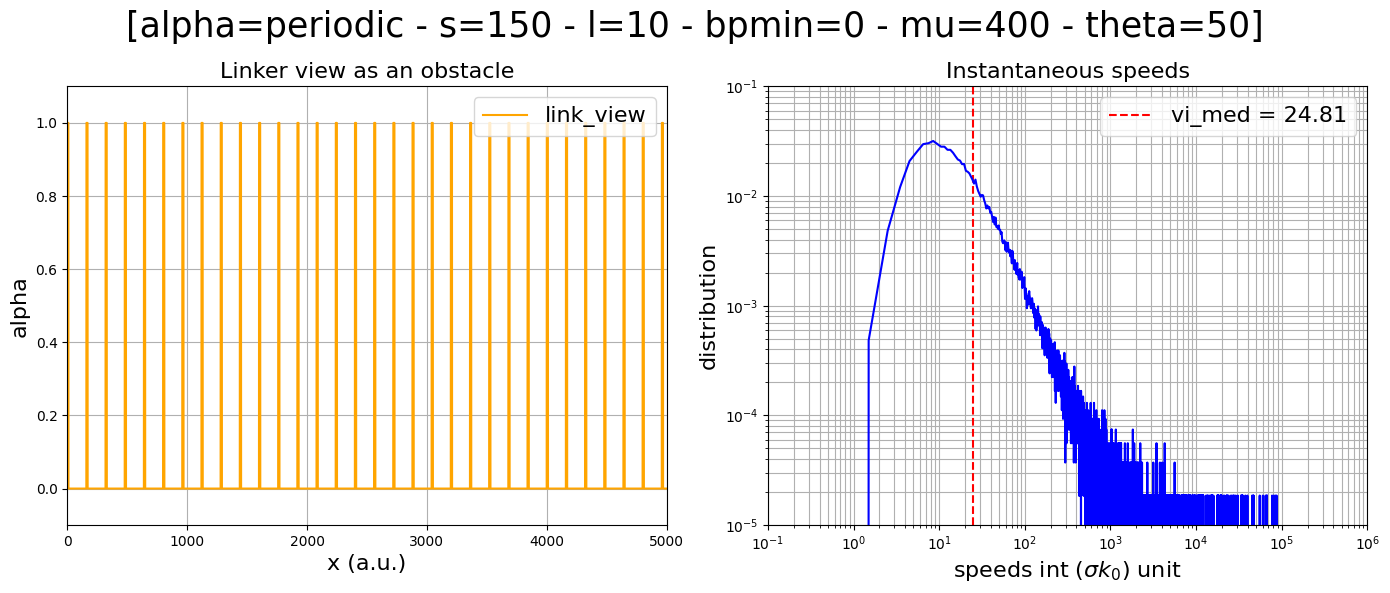

In [7]:
plot_functions = [
    (nclp.plot_linker_view, (sim_data.link_view,)),
    (nclp.plot_speed_distribution, (sim_data.vi_points, sim_data.vi_distrib, sim_data.vi_mean, sim_data.vi_med, sim_data.vi_mp))
]

fig, axes = plt.subplots(1, len(plot_functions), figsize=(14, 6))
axes = axes.flatten()

for i, (plot_func, args) in enumerate(plot_functions):
    plot_func(*args, ax=axes[i])

plt.suptitle(
    f'[alpha={sim_data.alpha_choice} - s={sim_data.s} - l={sim_data.l} - bpmin={sim_data.bpmin} - mu={sim_data.mu} - theta={sim_data.theta}]',
    fontsize=25
)
plt.tight_layout()
plt.show()

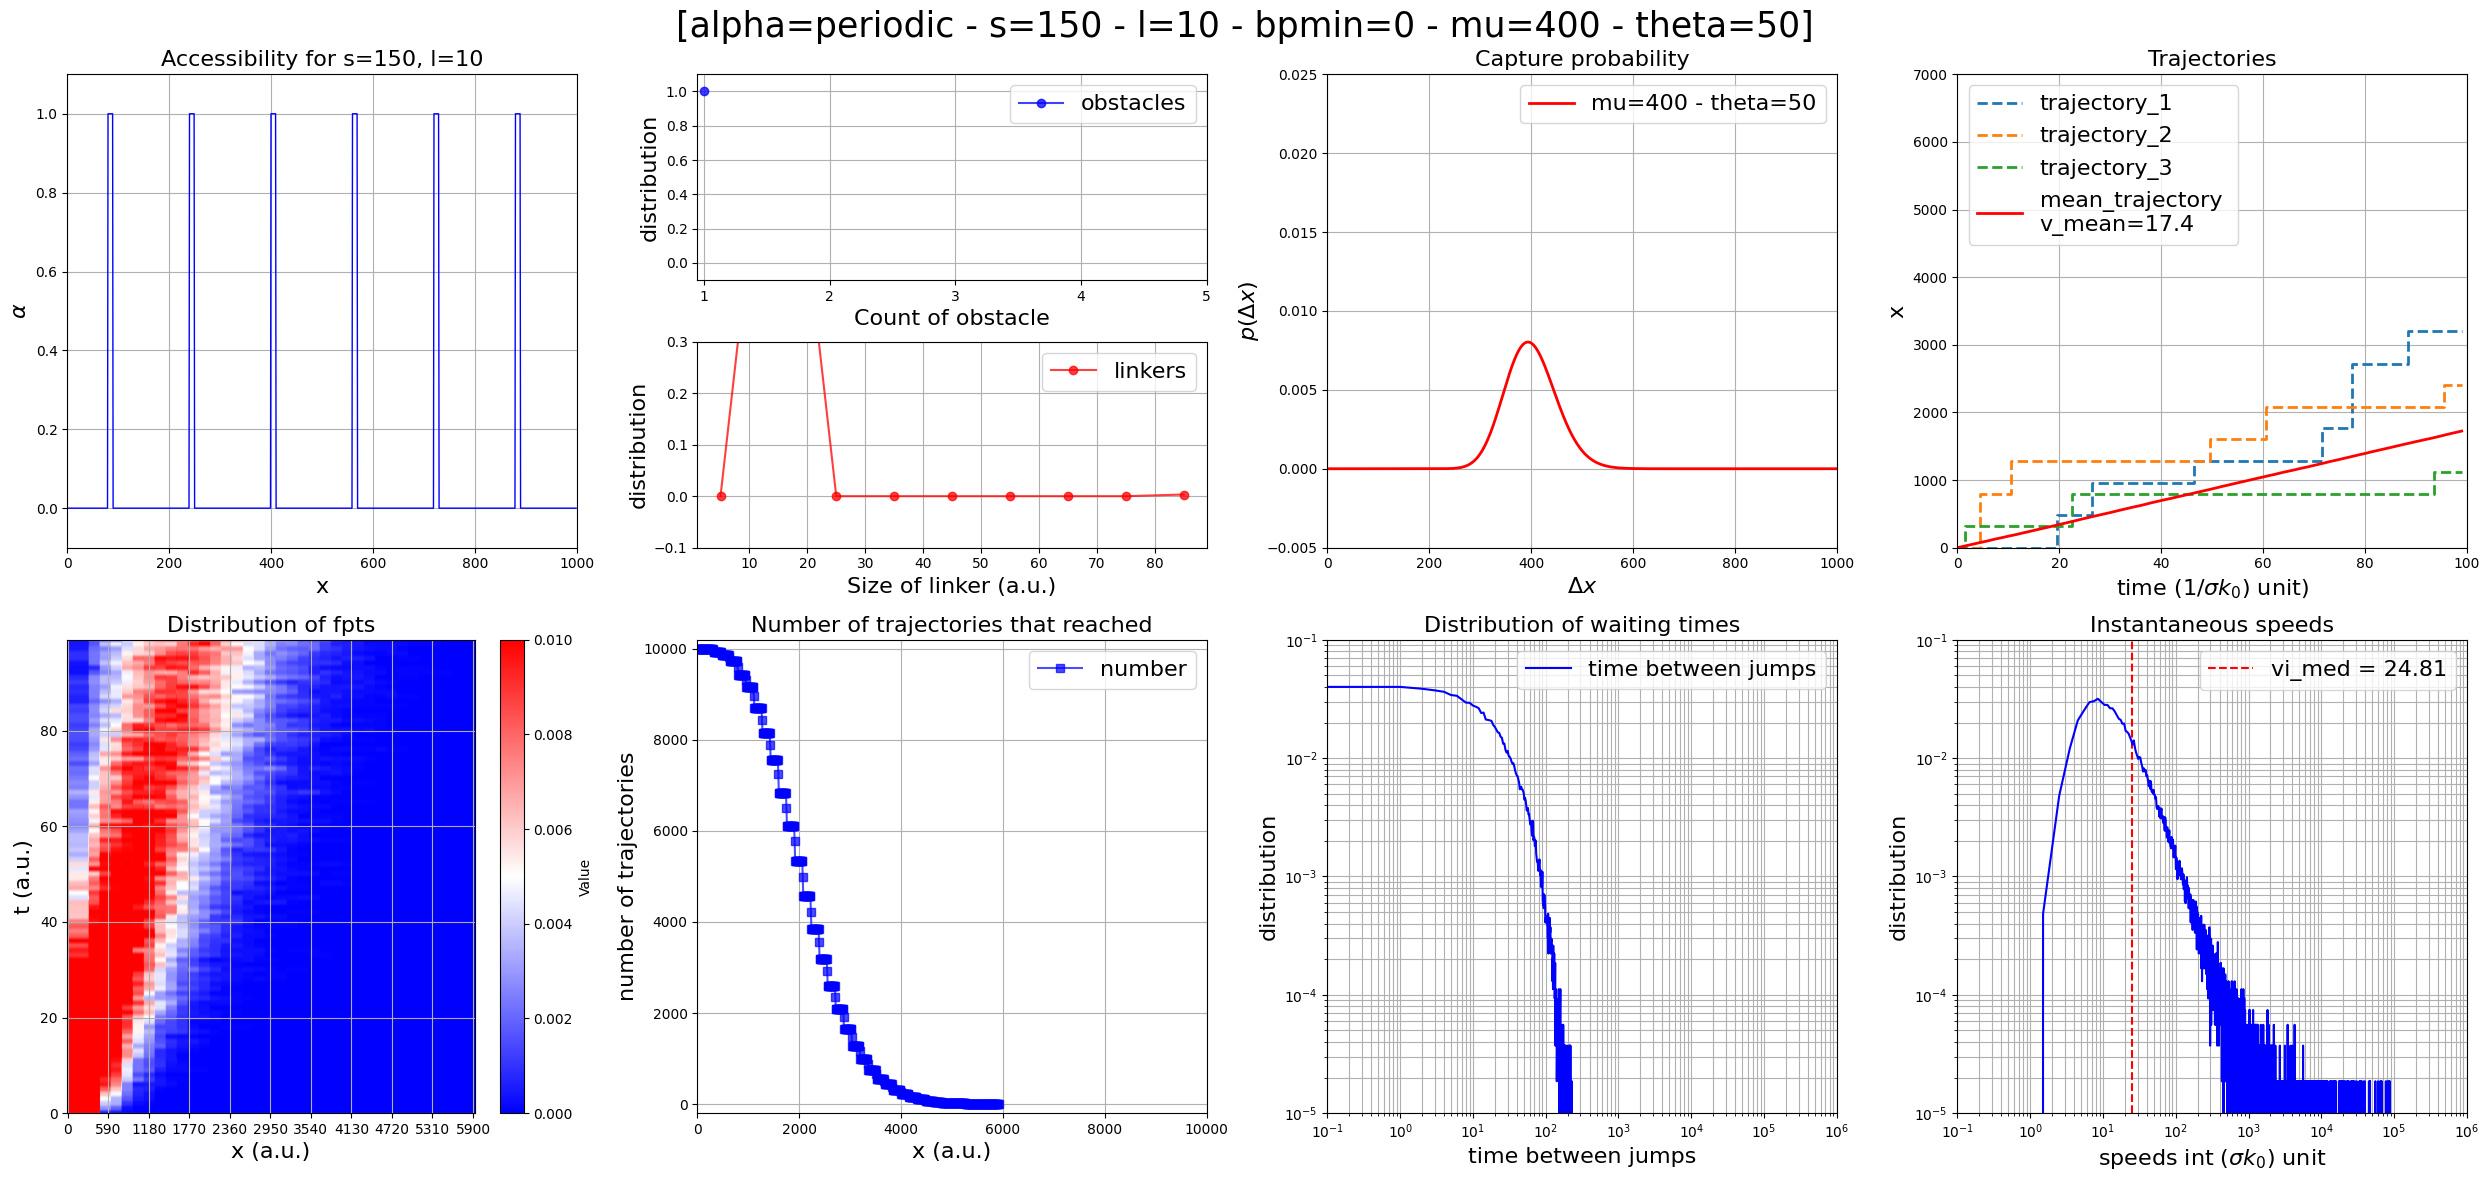

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(25, 12))
axes = axes.flatten()

plot_functions = [
    (nclp.plot_obstacle, (sim_data.s, sim_data.l, sim_data.origin, sim_data.alpha_mean)),
    (nclp.plot_obs_linker_distrib, (sim_data.s, sim_data.obs_points, sim_data.obs_distrib, sim_data.link_points, sim_data.link_distrib)),
    (nclp.plot_probabilities, (sim_data.mu, sim_data.theta, sim_data.p)),
    (nclp.plot_trajectories, (sim_data.tmax, sim_data.times, sim_data.results, sim_data.results_mean, sim_data.results_med, sim_data.results_std, sim_data.v_mean, sim_data.v_med)),
    (nclp.plot_fpt_distrib_2d, (sim_data.fpt_distrib_2D, sim_data.tmax, sim_data.bin_fpt)),
    (nclp.plot_fpt_number, (sim_data.nt, sim_data.tmax, sim_data.fpt_number, sim_data.bin_fpt)),
    (nclp.plot_waiting_times, (sim_data.tbj_points, sim_data.tbj_distrib)),
    (nclp.plot_speed_distribution, (sim_data.vi_points, sim_data.vi_distrib, sim_data.vi_mean, sim_data.vi_med, sim_data.vi_mp))
]

for i, (plot_func, args) in enumerate(plot_functions):
    plot_func(*args, ax=axes[i])

plt.suptitle(
    f'[alpha={sim_data.alpha_choice} - s={sim_data.s} - l={sim_data.l} - bpmin={sim_data.bpmin} - mu={sim_data.mu} - theta={sim_data.theta}]',
    fontsize=25
)
plt.tight_layout()
plt.show()

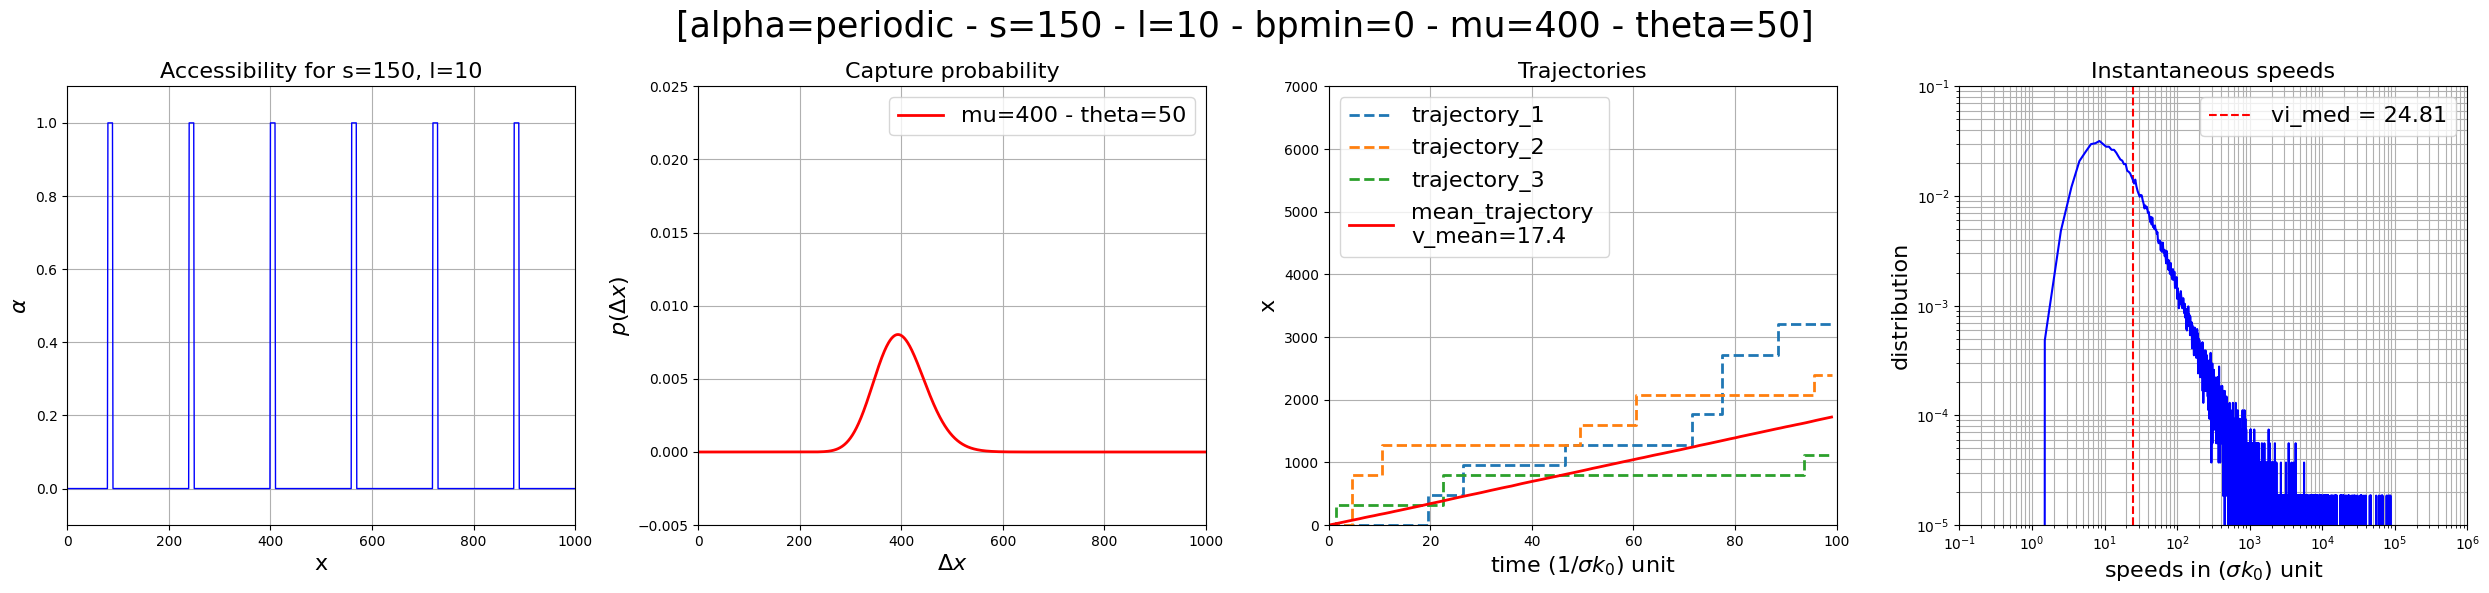

In [11]:
plot_functions = [
    (nclp.plot_obstacle, (sim_data.s, sim_data.l, sim_data.origin, sim_data.alpha_mean)),
    (nclp.plot_probabilities, (sim_data.mu, sim_data.theta, sim_data.p)),
    # (nclp.plot_linker_view, (sim_data.link_view,)),
    (nclp.plot_trajectories, (sim_data.tmax, sim_data.times, sim_data.results, sim_data.results_mean, sim_data.results_med, sim_data.results_std, sim_data.v_mean, sim_data.v_med)),
    (nclp.plot_speed_distribution, (sim_data.vi_points, sim_data.vi_distrib, sim_data.vi_mean, sim_data.vi_med, sim_data.vi_mp))
]

fig, axes = plt.subplots(1, len(plot_functions), figsize=(25, 6))
axes = axes.flatten()

for i, (plot_func, args) in enumerate(plot_functions):
    plot_func(*args, ax=axes[i])

plt.suptitle(
    f'[alpha={sim_data.alpha_choice} - s={sim_data.s} - l={sim_data.l} - bpmin={sim_data.bpmin} - mu={sim_data.mu} - theta={sim_data.theta}]',
    fontsize=25
)
plt.tight_layout()
plt.show()

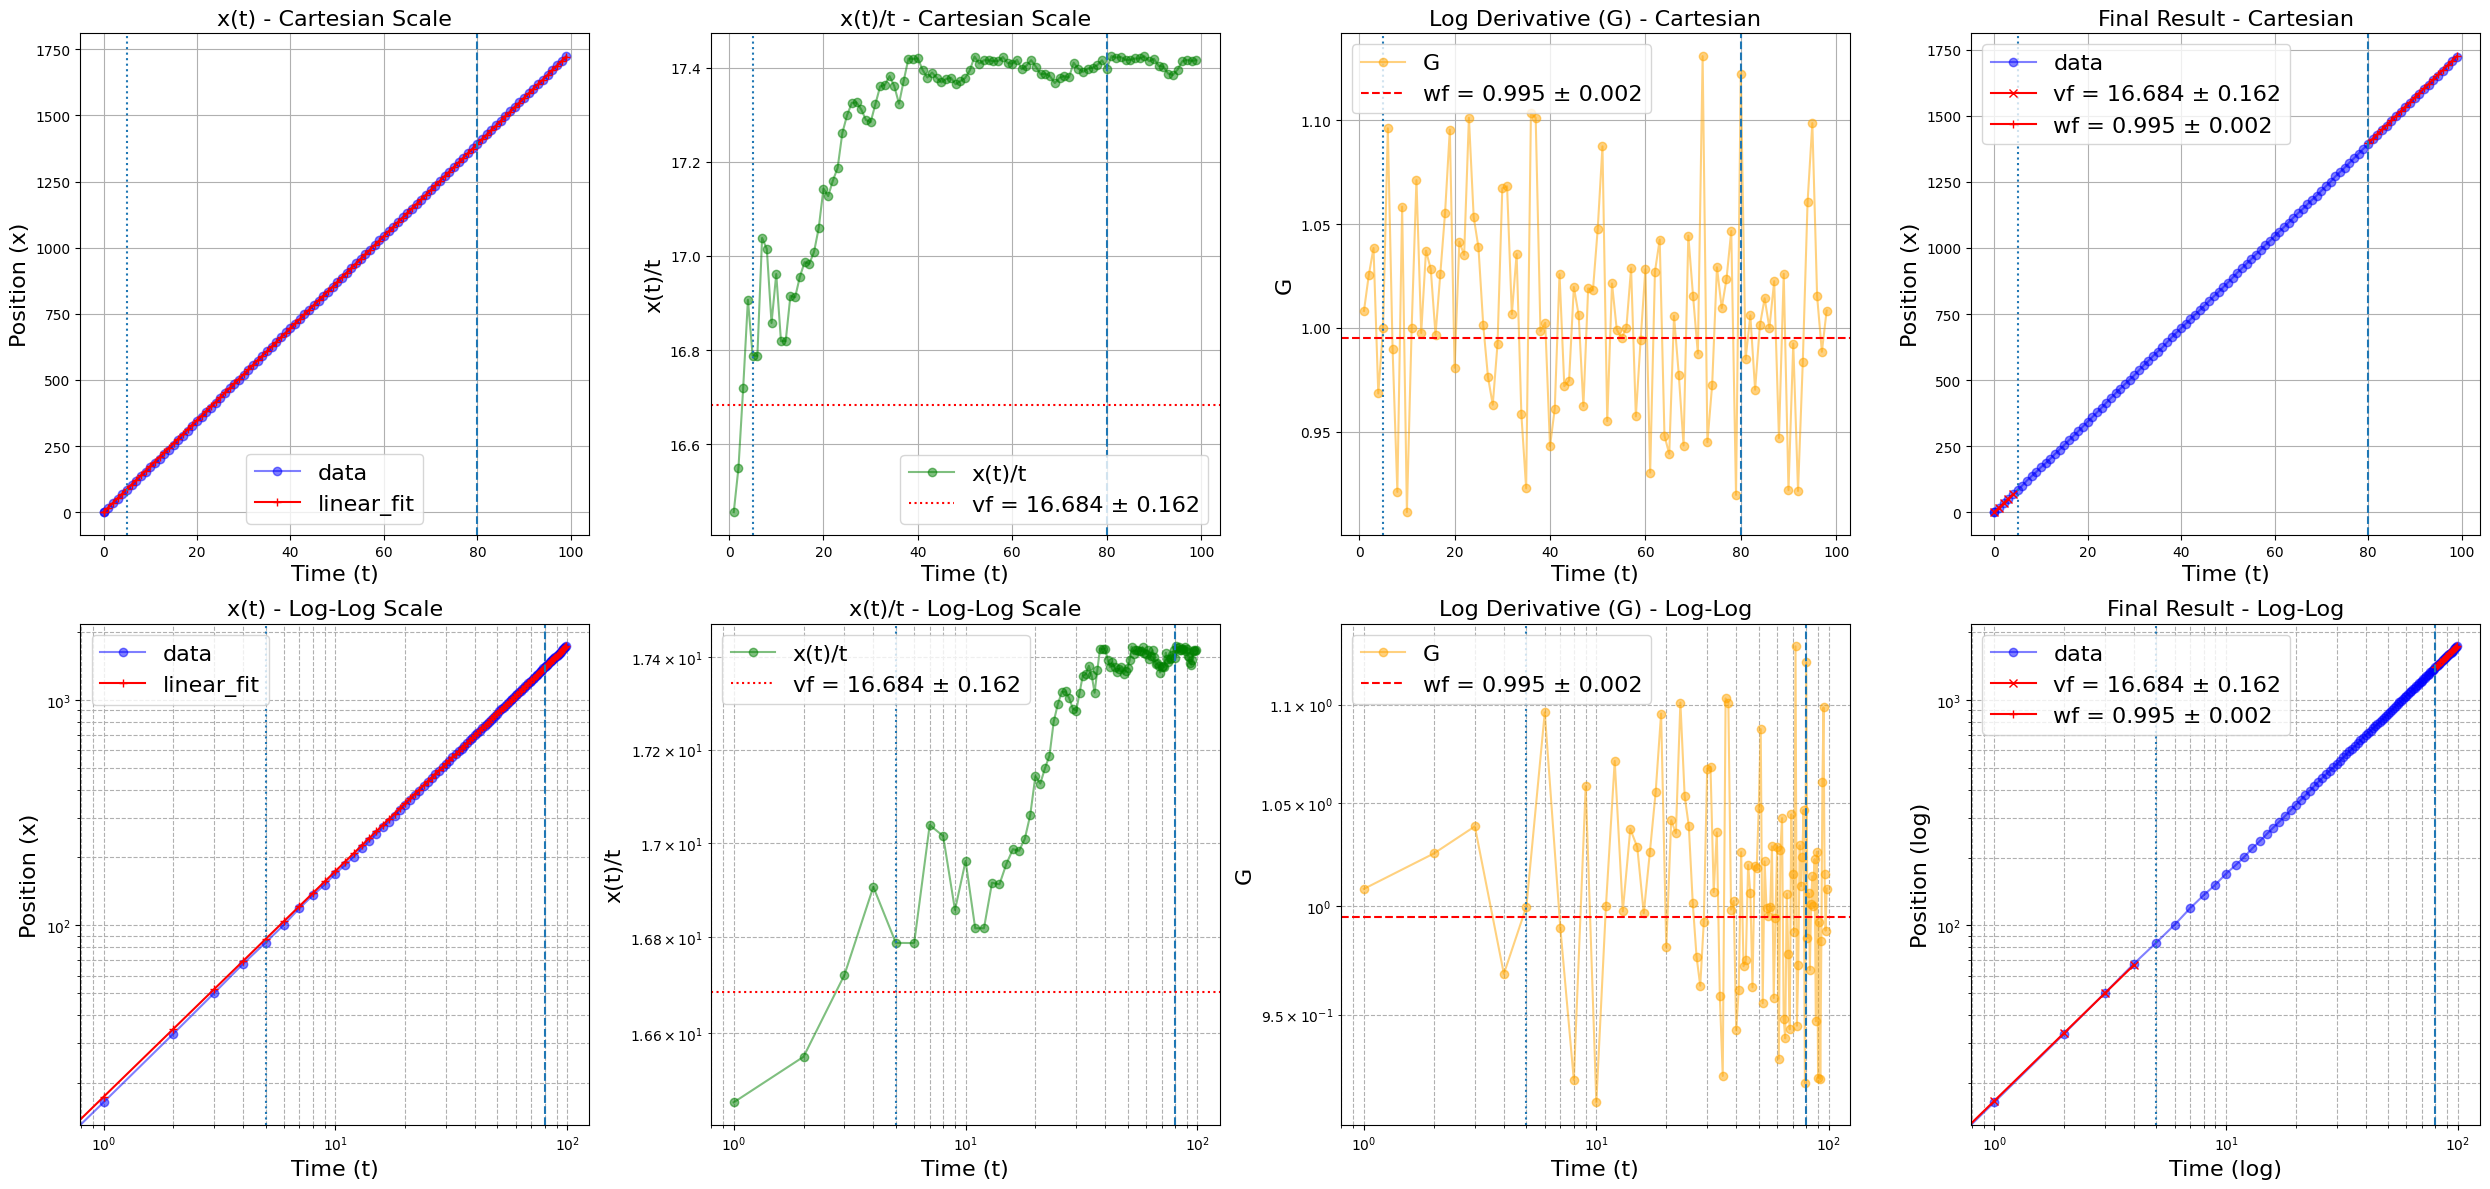

<Figure size 640x480 with 0 Axes>

In [8]:
nclp.plot_fitting_summary(
    sim_data.times,
    sim_data.results_mean,
    sim_data.v_mean,
    sim_data.xt_over_t,
    sim_data.G,
    sim_data.vf,
    sim_data.vf_std,
    sim_data.Cf,
    sim_data.Cf_std,
    sim_data.wf,
    sim_data.wf_std,
    bound_low=sim_data.bound_low,
    bound_high=sim_data.bound_high,
    rf=3,
    text_size=16,
    ax=None
)

plt.tight_layout()
plt.show()

# Work Area

In [24]:
# Future Function :

def work_find_parquet_and_load(     
        base_folder = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "2025-01-01_PSMN",
        **params
) -> pl.DataFrame:
    """
    Search for a parquet file in folder subfolders and check the specified values.
    Then load the parquet file as a Polars DataFrame.

    Args:
        root_directory (str): The root directory path to browse.
        **params: Keyword arguments representing the values to check in folder names.

    Returns:
        pl.DataFrame or None: Returns a Polars DataFrame if a matching file is found, otherwise None.
    """

    # List of subfolders in the root folder
    subdirs = [
        os.path.join(base_folder, d)
        for d in os.listdir(base_folder)
        if os.path.isdir(os.path.join(base_folder, d))
    ]

    # Main loop to iterate over subfolders
    for subdir in tqdm(subdirs, desc="Loading subfiles", unit=" subfiles"):
        for dirpath, dirnames, filenames in os.walk(subdir):  # Browse subfolders
            for dirname in dirnames:
                folder_name = dirname

                # Check if all parameters match in the folder name
                if all(f"{key}={value}__" in folder_name for key, value in params.items()):
                    # Path of the matching subfolder
                    subdir_path = os.path.join(dirpath, folder_name)
                    print(f"Corresponding subfile found: {subdir_path}")

                    # Look for .parquet files with 'data' in their name
                    for filename in os.listdir(subdir_path):
                        if filename.endswith('.parquet'):
                            pq_path = os.path.join(subdir_path, filename)
                            try:
                                # Load data using pyarrow and convert to Polars DataFrame
                                df_polars = pl.read_parquet(pq_path, use_statistics=True, low_memory=True)
                                pl.Config.set_tbl_cols(len(df_polars.columns))
                                print('File loaded and data availables')
                                return df_polars
                            except Exception as e:
                                print("Error loading parquet:", e)
                                return None

    # No matching folders found
    print("No sub-folders match the specified criteria.")
    return None


# Work Folder
work_folder = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "2025-12-11__PC"


# Work Parameters 1
work_params = {
    "landscape": "random",
    "s": 150,
    "l": 10,
    "bpmin": 0,
    
    "mu": 180,
    "theta": 90,
    
    "nt": 10_000,
}
# Call 1
work_df = work_find_parquet_and_load(
    base_folder = work_folder,
    **work_params
)
print(work_df)



Loading subfiles:   0%|          | 0/1 [00:00<?, ? subfiles/s]

Corresponding subfile found: /home/nicolas/Documents/PhD/Workspace/nucleo/outputs/2025-12-11__PC/nucleo__access_0/formalism=1__landscape=random__s=150__l=10__bpmin=0__mu=180__theta=90__lmbda=0.00e+00__rtotcapt=0.00e+00__rtotrest=0.00e+00__alphar=0.00e+00__kB=5.00e-01__kU=5.00e-01__parameter=0.00e+00__nt=10000__
File loaded and data availables
shape: (1, 79)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ for ┆ lan ┆ s   ┆ l   ┆ bpm ┆ mu  ┆ the ┆ alp ┆ alp ┆ bet ┆ lmb ┆ rto ┆ rto ┆ alp ┆ kB  ┆ kU  ┆ par ┆ Lmi ┆ Lma ┆ bps ┆ ori ┆ tma ┆ dt  ┆ tim ┆ bin ┆ bin ┆ nt  ┆ 

In [25]:
from dataclasses import dataclass
import numpy as np
import polars as pl


@dataclass(slots=True, kw_only=True, frozen=True)
class SimulationData:

    # Inputs
    landscape: str
    s: int
    l: int
    bpmin: int
    mu: float
    theta: float
    alphaf: float
    alphao: float
    beta: float
    lmbda: float
    rtot_capt: float
    rtot_rest: float
    alphar: float
    kB: float
    kU: float
    parameter: float
    Lmin: int
    Lmax: int
    bps: int
    origin: int
    tmax: float
    dt: float
    times: np.ndarray
    binx: int
    bint: int
    nt: int

    # Obstacle
    s_mean: float
    s_points: np.ndarray
    s_distrib: np.ndarray
    l_mean: float
    l_points: np.ndarray
    l_distrib: np.ndarray
    l_view: np.ndarray
    alpha_mean_p: np.ndarray
    alpha_mean_v: float

    # Probabilities
    p: np.ndarray

    # Results
    results: np.ndarray
    results_mean: np.ndarray
    results_med: np.ndarray
    results_std: np.ndarray
    v_mean: float
    v_med: float
    v_th_sim: float
    v_th_eff: float

    # Fit
    vf: float
    Cf: float
    wf: float
    vf_std: float
    Cf_std: float
    wf_std: float

    # Jump statistics
    xbj_points: np.ndarray
    xbj_distrib: np.ndarray
    tbj_points: np.ndarray
    tbj_distrib: np.ndarray

    # First passage times
    fpt_distrib_2D: np.ndarray
    fpt_number: np.ndarray

    # Instantaneous speeds
    dx_points: np.ndarray
    dx_distrib: np.ndarray
    dx_mean: float
    dx_med: float
    dx_mp: float

    dt_points: np.ndarray
    dt_distrib: np.ndarray
    dt_mean: float
    dt_med: float
    dt_mp: float

    vi_points: np.ndarray
    vi_distrib: np.ndarray
    vi_mean: float
    vi_med: float
    vi_mp: float

    # Last parameters
    alpha0: float

    # Plot helpers
    xt_over_t: np.ndarray
    G: np.ndarray
    bound_low: float
    bound_high: float

    # ---------------------------
    # --- DataFrame loader ------
    # ---------------------------
    @classmethod
    def from_polars(cls, df: pl.DataFrame):
        if df.height == 0:
            raise ValueError("Empty DataFrame")
        if df.height > 1:
            df = df.head(1)

        row = df.row(0, named=True)

        # convert to numpy only for some keys
        def to_np(x):
            return x if isinstance(x, np.ndarray) else np.asarray(x)

        np_keys = {
            "times","alpha_mean","obs_points","obs_distrib",
            "link_points","link_distrib","link_view","p","results",
            "results_mean","results_med","results_std",
            "fpt_distrib_2D","fpt_number","tbj_points","tbj_distrib",
            "dx_points","dx_distrib","dt_points","dt_distrib",
            "vi_points","vi_distrib","xt_over_t","G"
        }

        # --- NEW: filter unknown columns ---
        allowed_keys = set(cls.__annotations__.keys())
        filtered_row = {k: v for k, v in row.items() if k in allowed_keys}

        # convert needed arrays
        converted = {
            k: (to_np(v) if k in np_keys else v)
            for k, v in filtered_row.items()
        }

        return cls(**converted)


# Extracting
sim_data = SimulationData.from_polars(work_df)
print("Values loaded")

Values loaded


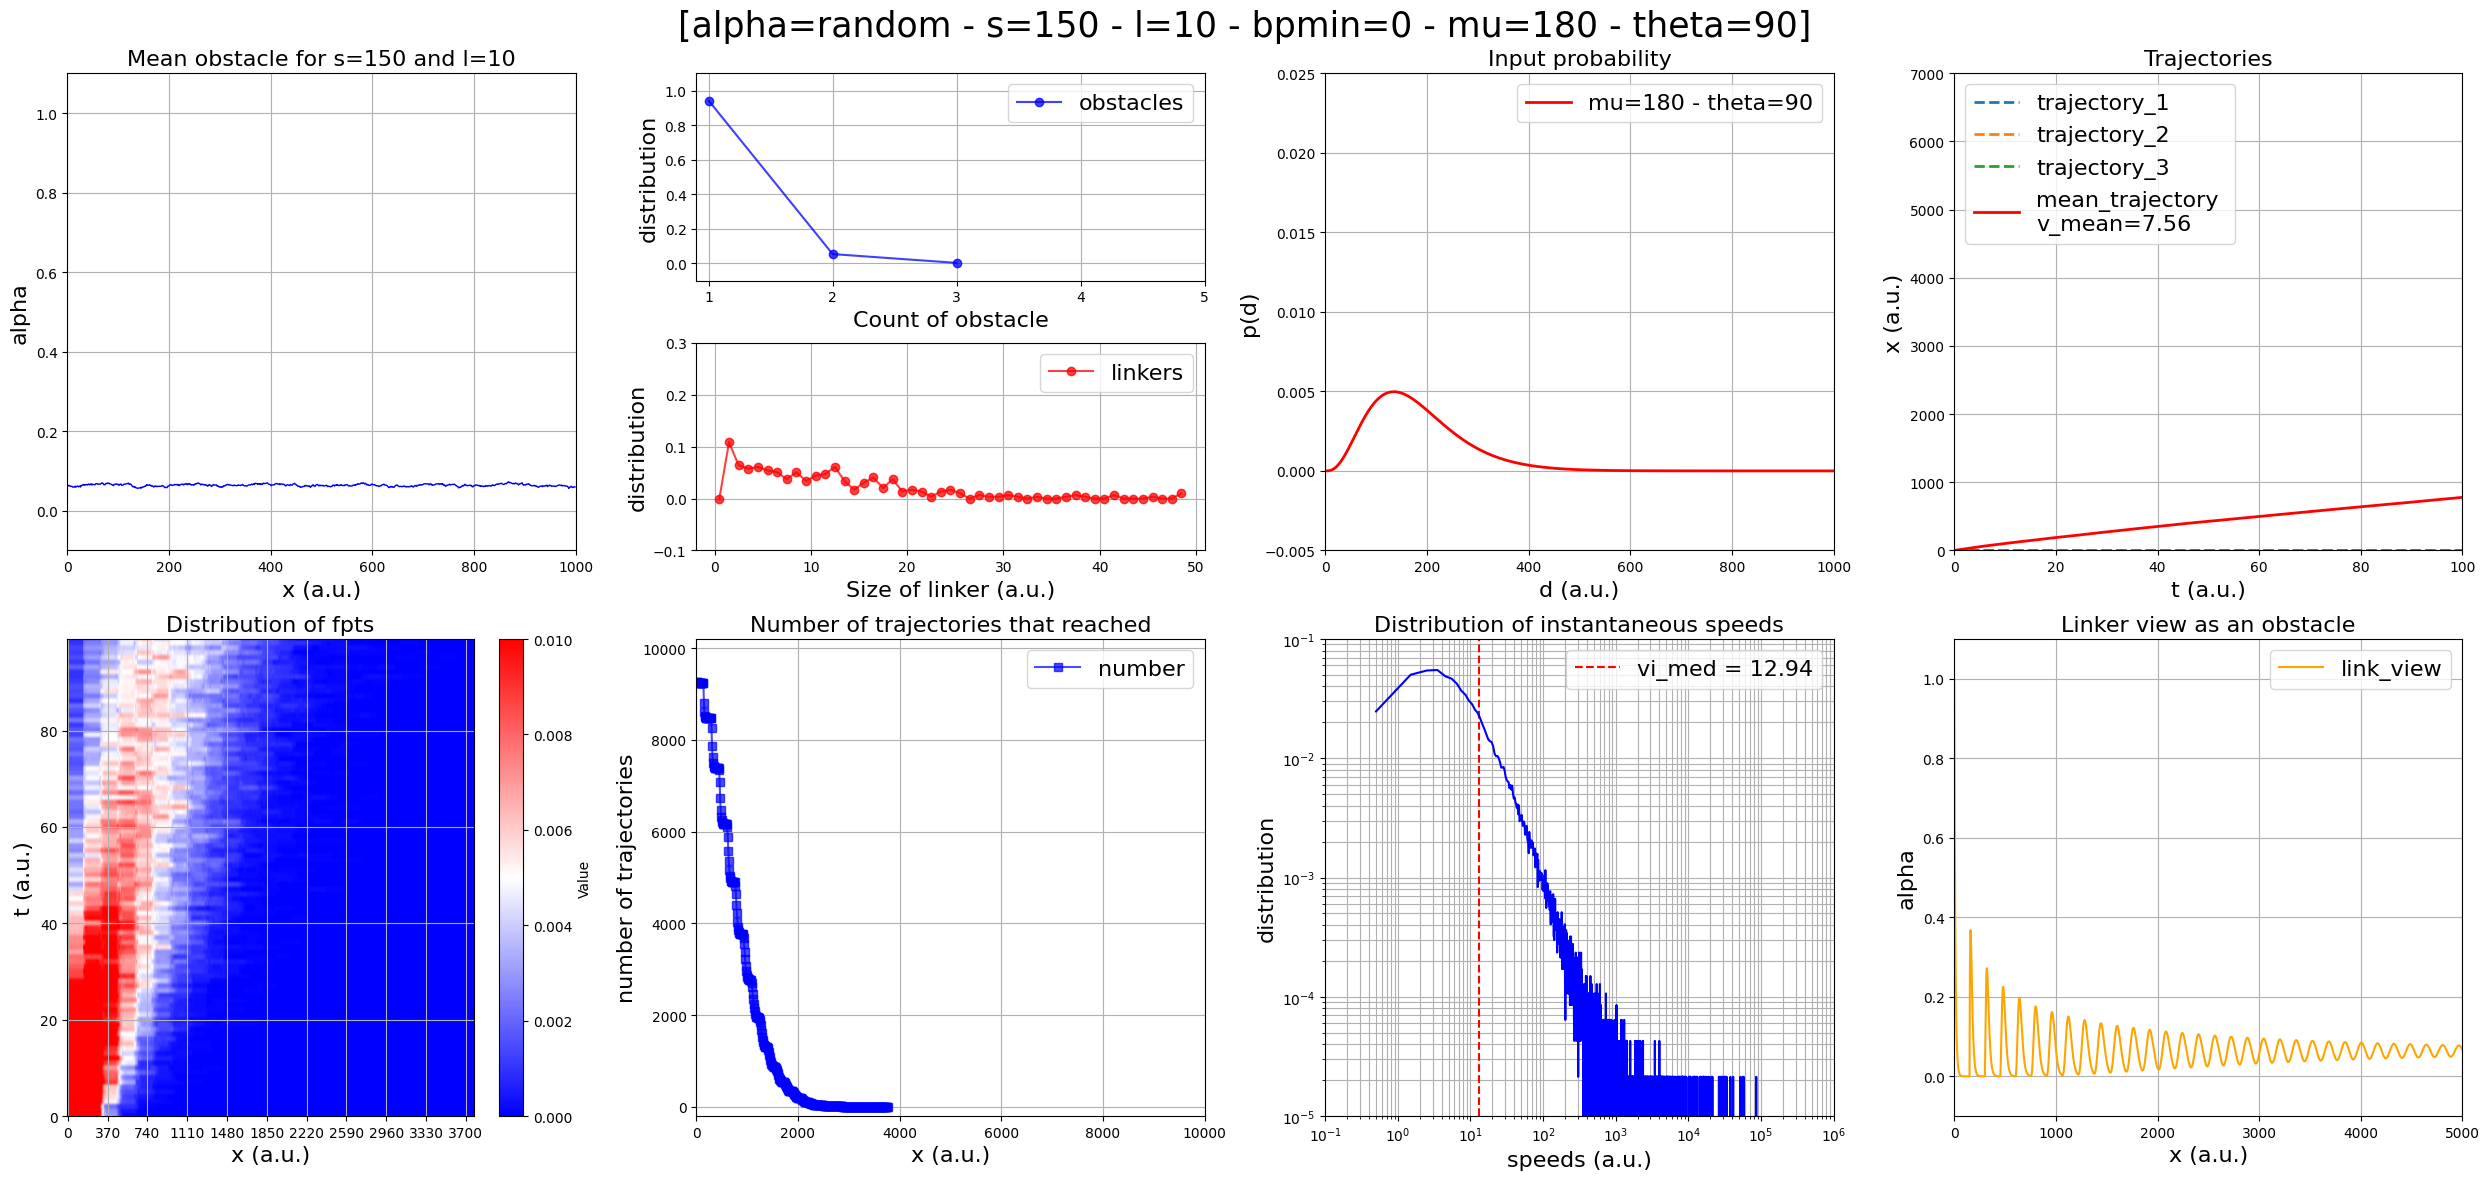

In [52]:
fig, axes = plt.subplots(2, 4, figsize=(25, 12))
axes = axes.flatten()

plot_functions = [
    (nclp.plot_obstacle, (sim_data.s, sim_data.l, sim_data.origin, sim_data.alpha_mean_p)),
    (nclp.plot_obs_linker_distrib, (sim_data.s, sim_data.s_points, sim_data.s_distrib, sim_data.l_points, sim_data.l_distrib)),
    (nclp.plot_probabilities, (sim_data.mu, sim_data.theta, sim_data.p)),
    (nclp.plot_trajectories, (sim_data.tmax, sim_data.times, sim_data.results, sim_data.results_mean, sim_data.results_med, sim_data.results_std, sim_data.v_mean, sim_data.v_med)),
    (nclp.plot_fpt_distrib_2d, (sim_data.fpt_distrib_2D, sim_data.tmax, sim_data.bint)),
    (nclp.plot_fpt_number, (sim_data.nt, sim_data.tmax, sim_data.fpt_number, sim_data.bint)),
    (nclp.plot_speed_distribution, (sim_data.vi_points, sim_data.vi_distrib, sim_data.vi_mean, sim_data.vi_med, sim_data.vi_mp)),
    (nclp.plot_linker_view, (sim_data.l_view,))
]

for i, (plot_func, args) in enumerate(plot_functions):
    plot_func(*args, ax=axes[i])

plt.suptitle(
    f'[alpha={sim_data.landscape} - s={sim_data.s} - l={sim_data.l} - bpmin={sim_data.bpmin} - mu={sim_data.mu} - theta={sim_data.theta}]',
    fontsize=25
)
plt.tight_layout()
plt.show()

# .